# display validation result

In [1]:
import scipy.misc as misc
import os
import numpy as np
import sys
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve

sys.path.append(os.path.realpath('../metrics'))
from eval_segm import *
from seg_metric import SegMetric


imageFileName = ['11ska595800{}', '11ska460755{}', '11ska580860{}', '11ska565845{}']
num_val = imageFileName.__len__()

truthDir = os.path.expanduser('~/Documents/data/igarssTrainingAndTestingData/imageFiles')

In [2]:
image = misc.imread(os.path.join(truthDir,imageFileName[0].format('.png')))
truth = (misc.imread(os.path.join(truthDir,imageFileName[0].format('_truth.png')))/255).astype(np.uint8)

/home/helios/anaconda3/envs/TF/lib/python3.5/site-packages/scipy/ndimage/measurements.py:1284: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


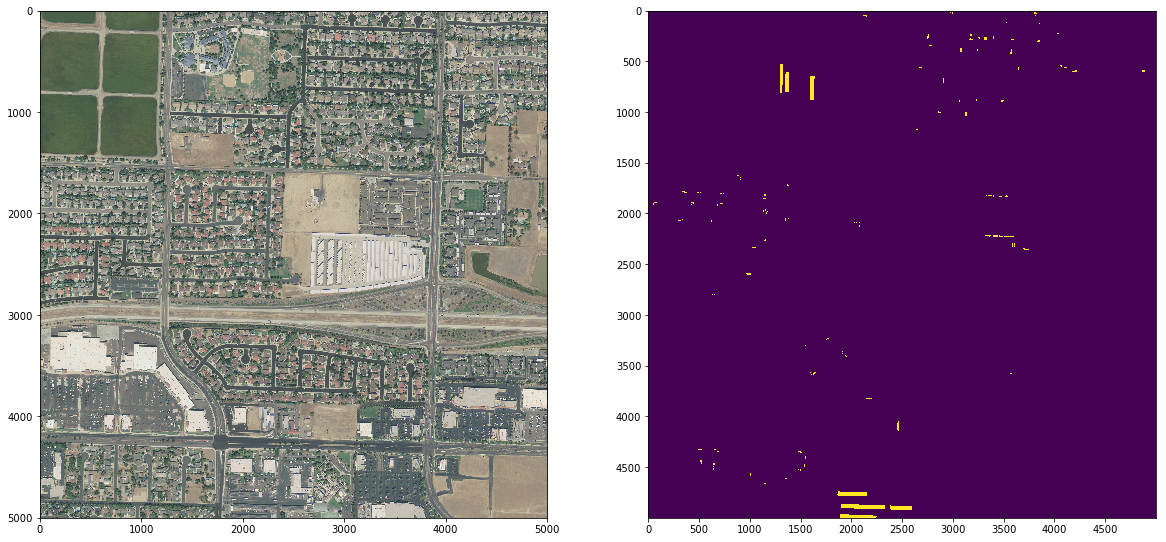

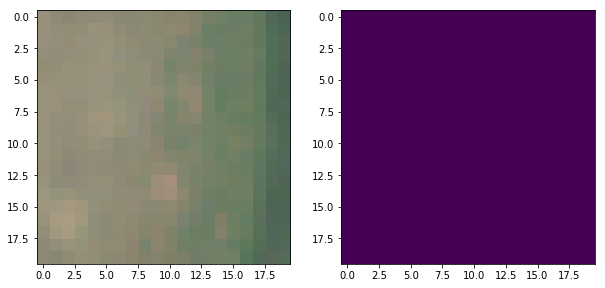

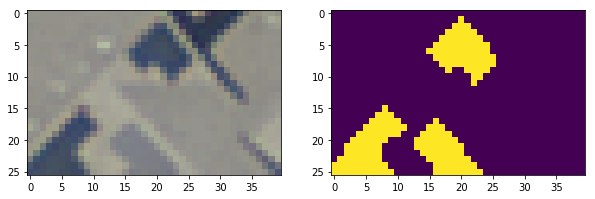

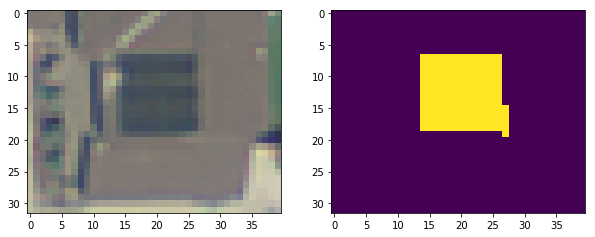

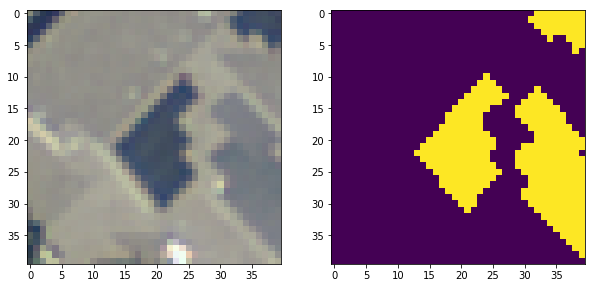

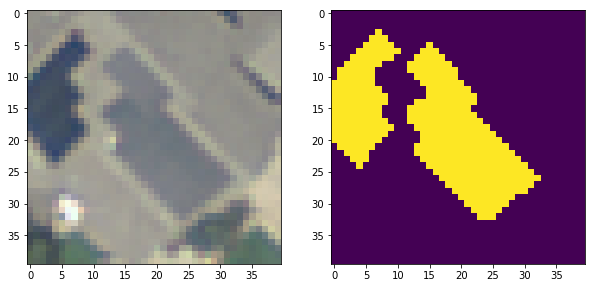

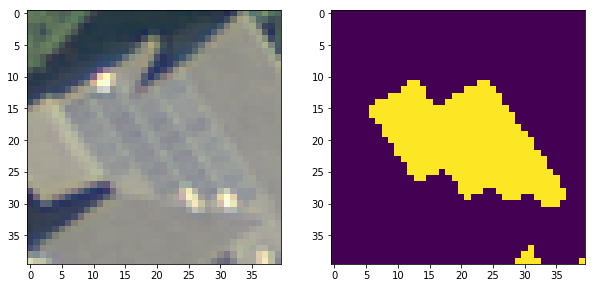

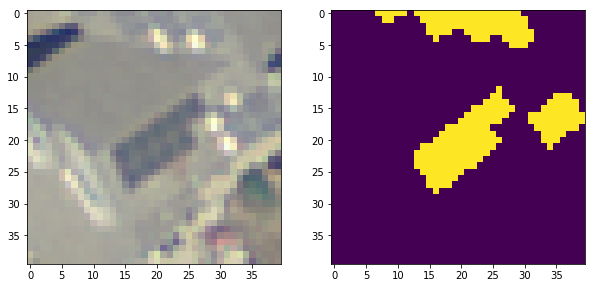

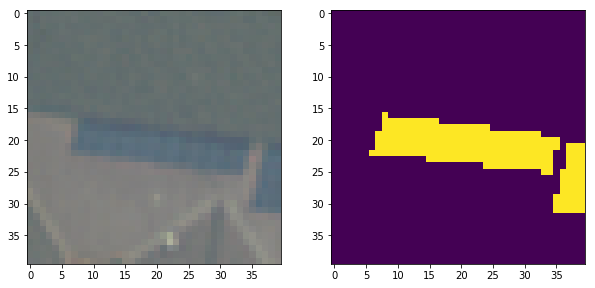

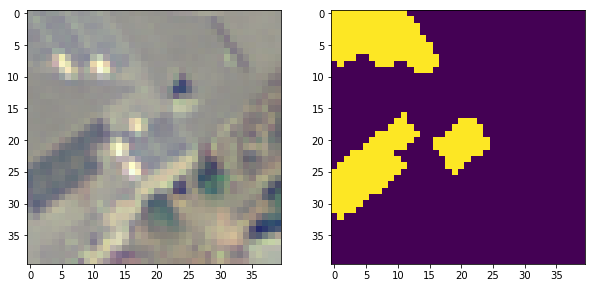

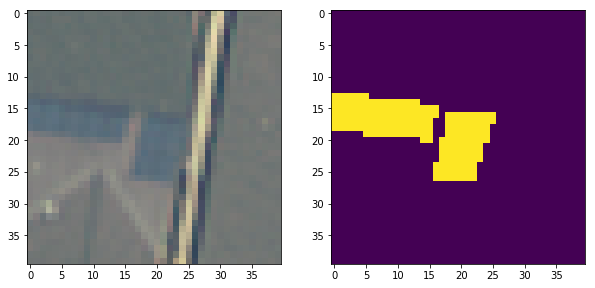

In [3]:
from scipy.ndimage.measurements import *
objects = find_objects(label(truth)[0])
region_center = np.nan_to_num(center_of_mass(truth, label(truth)[0], range(label(truth)[1])))
# region_center=np.array([[800, 1500], [4400, 600]])
patch_size = 100
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(truth)
plt.xticks(np.arange(0, 5000, 500))
plt.yticks(np.arange(0, 5000, 500))

for i in range(10):
#     left_up = region_center[i,:] -patch_size
#     right_bottom = region_center[i,:] +patch_size
    
    left_up = np.max(np.array([region_center[i] - patch_size, np.array([0, 0])]), axis=0).astype(int)
    right_bottom = np.min(np.array([region_center[i] + patch_size, np.array([5000, 5000])]), axis=0).astype(int)
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(image[left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]])
    plt.subplot(1, 2, 2)
    plt.imshow(truth[left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]])
#     plt.figure(figsize=(20,20))
#     plt.subplot(1, 2, 1)
#     plt.imshow(image[objects[i]])
#     plt.subplot(1, 2, 2)
#     plt.imshow(truth[objects[i]])

# Evaluate FCN

Image 11ska595800: 0.6087
Image 11ska460755: 0.2059
Image 11ska580860: 0.2873
Image 11ska565845: 0.0799
Overal mean IoU: 0.4490


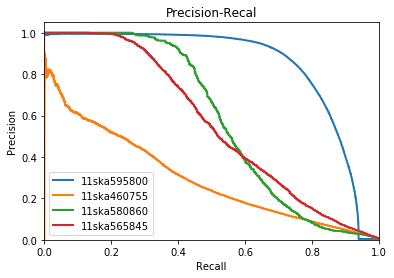

In [50]:
batch_size=128
validDir = os.path.join(os.path.realpath('../FCN/logs'), 'logs_batch%d' % batch_size,'images')
seg_metric = SegMetric(1)
plt.figure("PR Curve")
for i in range(0, num_val):
    image = misc.imread(os.path.join(truthDir,imageFileName[i].format('.png')))
    truth = (misc.imread(os.path.join(truthDir,imageFileName[i].format('_truth.png')))/255).astype(np.uint8)
    valid_pmap = misc.imread(os.path.join(validDir,imageFileName[i].format('_valid_pmap.tif')))
    pred_binary = (valid_pmap>0.5).astype(np.uint8)
    
    # mean IoU
    seg_metric.add_image_pair(pred_binary, truth)
    print("Image {}: {:.4f}".format(imageFileName[i][0:-2],mean_IU(pred_binary, truth)))
    
    # RP curve
    # Plot PR curve
    plt.figure("PR Curve")
    precision, recall, thresholds = precision_recall_curve(truth.flatten(), valid_pmap.flatten(), 1)
    
    plt.plot(recall, precision, lw=2,
             label=imageFileName[i][0:-2])
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recal')
    
print("Overal mean IoU: {:.4f}".format(seg_metric.mean_IU()))

# Evaluate DeepLab

Evaluate batchsize20 LR1e-05
mean_IoU of image 11ska595800: 0.6699
mean_IoU of image 11ska460755: 0.2417
mean_IoU of image 11ska580860: 0.3921
mean_IoU of image 11ska565845: 0.1356
Overal mean IoU of batchsize20 LR1e-05: 0.5441
Evaluate batchsize40 LR1e-04
mean_IoU of image 11ska595800: 0.7257
mean_IoU of image 11ska460755: 0.2931
mean_IoU of image 11ska580860: 0.4745
mean_IoU of image 11ska565845: 0.2937
Overal mean IoU of batchsize40 LR1e-04: 0.6432
Evaluate batchsize20 LR1e-03
mean_IoU of image 11ska595800: 0.7245
mean_IoU of image 11ska460755: 0.3274
mean_IoU of image 11ska580860: 0.2220
mean_IoU of image 11ska565845: 0.1181
Overal mean IoU of batchsize20 LR1e-03: 0.5671


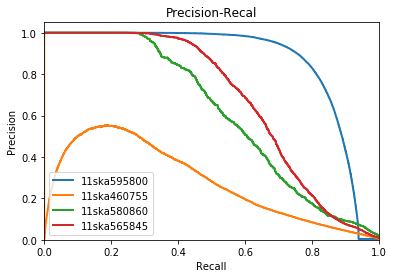

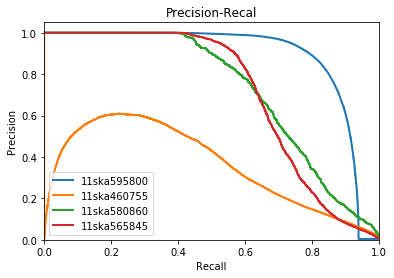

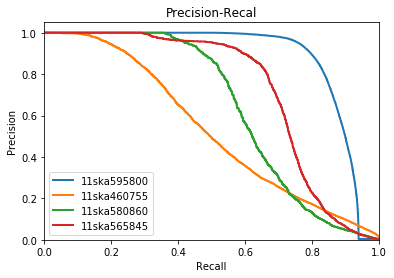

In [51]:
learning_rates = [1e-5, 1e-4, 1e-3]
weight_decay = 0.0005
batch_sizes = [20]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
            if learning_rate == 1e-4:
                batch_size = 40
            validDir = os.path.join(os.path.realpath('../../tensorflow-deeplab-resnet/snapshots/train_with_pretrained_model'), 'sc_all_batchsize{}_learningRate_{:.0e}_weight_decay_{}/'.format(batch_size, learning_rate, weight_decay),'images')
            seg_metric = SegMetric(1)
            plt.figure("PR Curve batchsize{} LR{:.0e}".format(batch_size, learning_rate))
            print("Evaluate batchsize{} LR{:.0e}".format(batch_size, learning_rate))
            for i in range(0, 4):
                image = misc.imread(os.path.join(truthDir,imageFileName[i].format('.png')))
                truth = (misc.imread(os.path.join(truthDir,imageFileName[i].format('_truth.png')))/255).astype(np.uint8)
                valid_pmap = misc.imread(os.path.join(validDir,imageFileName[i].format('_valid_pmap.tif')))
                pred_binary = misc.imread(os.path.join(validDir,imageFileName[i].format('_valid_pred.png')))
#                 pred_binary = (valid_pmap>0.5).astype(np.uint8)
                seg_metric.add_image_pair(pred_binary, truth)
                print("mean_IoU of image {}: {:.4f}".format(imageFileName[i][0:-2],mean_IU(pred_binary, truth)))
                
                # plot PR curve
                plt.figure("PR Curve batchsize{} LR{:.0e}".format(batch_size, learning_rate))
                precision, recall, thresholds = precision_recall_curve(truth.flatten(), valid_pmap.flatten(), 1)
                plt.plot(recall, precision, lw=2,
                         label=imageFileName[i][0:-2])
                plt.legend()
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.ylim([0.0, 1.05])
                plt.xlim([0.0, 1.0])
                plt.title('Precision-Recal')
                
            print("Overal mean IoU of batchsize{} LR{:.0e}: {:.4f}".format(batch_size, learning_rate, seg_metric.mean_IU()))

# Analyze prediction in patches

In [52]:
# mean IoU for ROIs
import scipy.misc as misc
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from scipy.ndimage.measurements import *
from skimage import measure

sys.path.append(os.path.realpath('../metrics'))
from eval_segm import *
from seg_metric import SegMetric

batch_size = 128
learning_rate = 1e-3

imageFileName = ['11ska595800{}', '11ska460755{}', '11ska580860{}', '11ska565845{}']
num_val = imageFileName.__len__()

truthDir = os.path.expanduser('~/Documents/data/igarssTrainingAndTestingData/imageFiles')
validDir = [os.path.join(os.path.realpath('../FCN/logs'), 'logs_batch%d' % batch_size,'images')]
learning_rates = [1e-4]
weight_decay = 0.0005
batch_sizes = [20]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
            if learning_rate == 1e-4:
                batch_size = 40
            validDir.append(os.path.join(os.path.realpath('../../tensorflow-deeplab-resnet/snapshots/train_with_pretrained_model'), 'sc_all_batchsize{}_learningRate_{:.0e}_weight_decay_{}/'.format(batch_size, learning_rate, weight_decay),'images'))
pred_binary = []



seg_metric = SegMetric(1)

meanIoUs = []
mean_performance = []
variance_performance =[]
patch_size = 20
for i in range(0, 1):
    image = misc.imread(os.path.join(truthDir, imageFileName[i].format('.png')))
    truth = (misc.imread(os.path.join(truthDir, imageFileName[i].format('_truth.png'))) / 255).astype(np.uint8)
    region_center = np.nan_to_num(center_of_mass(truth, label(truth)[0], range(label(truth)[1])))
    meanIoU = np.zeros([region_center.__len__()-1, validDir.__len__()])

    for l in range(validDir.__len__()):
        pred_binary.append(((misc.imread(os.path.join(validDir[l], imageFileName[i].format('_valid_pmap.tif'))))>0.5).astype(int))

    for j in range(1, region_center.shape[0]):
        left_up = np.max(np.array([region_center[j] - patch_size, np.array([0, 0])]), axis=0).astype(int)
        right_bottom = np.min(np.array([region_center[j] + patch_size, np.array([5000, 5000])]), axis=0).astype(int)
        image_patch = image[left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
        truth_patch = truth[left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
        for k in range(validDir.__len__()):
            pred_patch = pred_binary[k][left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
            meanIoU[j-1,k] = mean_IU(pred_patch, truth_patch)
    mean_performance.append(np.mean(meanIoU, axis=1))
    variance_performance.append(np.var(meanIoU, axis=1))
    meanIoUs.append(meanIoU)

/home/helios/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1284: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


/home/helios/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1284: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


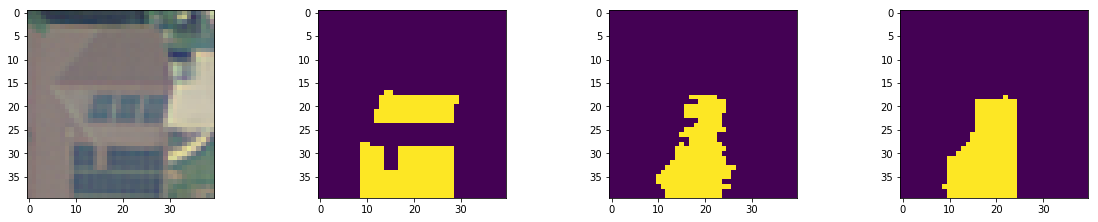

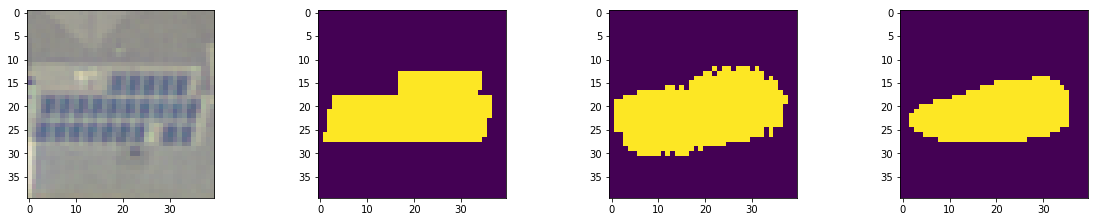

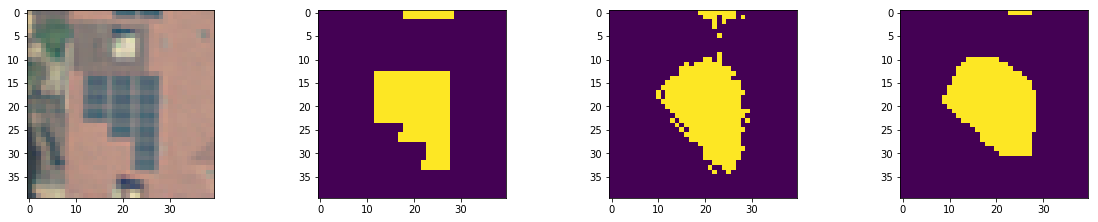

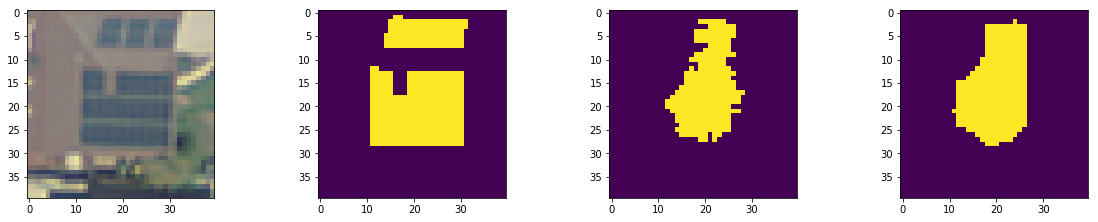

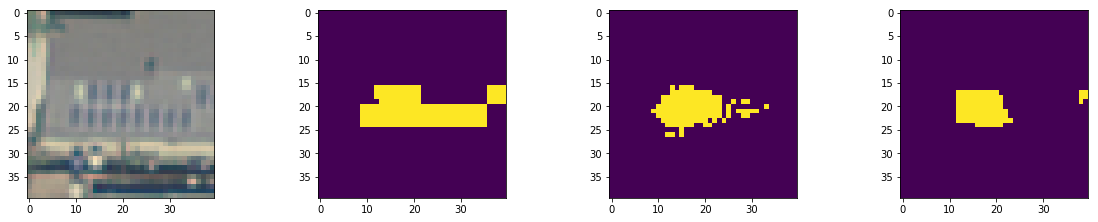

In [56]:
for i in range(0, 1):
    image = misc.imread(os.path.join(truthDir, imageFileName[i].format('.png')))
    truth = (misc.imread(os.path.join(truthDir, imageFileName[i].format('_truth.png'))) / 255).astype(np.uint8)
    region_center = np.nan_to_num(center_of_mass(truth, label(truth)[0], range(label(truth)[1])))
    
    mean_ind = np.argsort(mean_performance[0])
    var_ind = np.argsort(variance_performance[0])
    
    num_sample = 5
    ind = np.random.permutation(10)
    # worst
    for j in range(0, num_sample):
        
        left_up = np.max(np.array([region_center[mean_ind[j]] - patch_size, np.array([0, 0])]), axis=0).astype(int)
        right_bottom = np.min(np.array([region_center[mean_ind[j]] + patch_size, np.array([5000, 5000])]), axis=0).astype(int)
        image_patch = image[left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
        truth_patch = truth[left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
        plt.figure('worst{}'.format(j), figsize=(20,20))
        plt.subplot(num_sample, validDir.__len__()+2, (validDir.__len__()+2)*j+1)
        plt.imshow(image_patch)
        plt.subplot(num_sample, validDir.__len__()+2, (validDir.__len__()+2)*j+2)
        plt.imshow(truth_patch)
        for k in range(validDir.__len__()):
            pred_patch = pred_binary[k][left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
            plt.subplot(num_sample, validDir.__len__()+2, (validDir.__len__()+2)*j+3+k)
            plt.imshow(pred_patch)

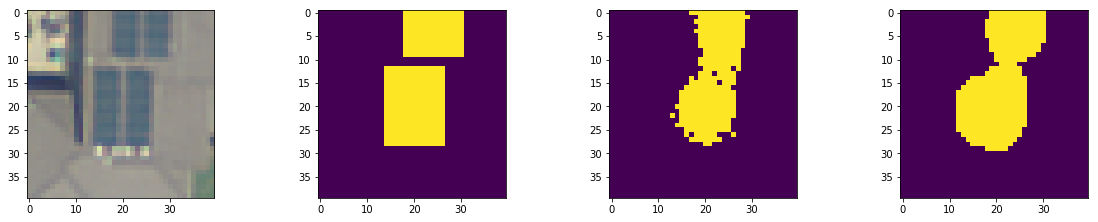

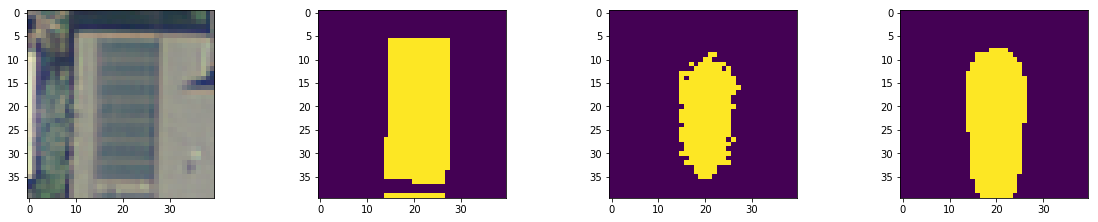

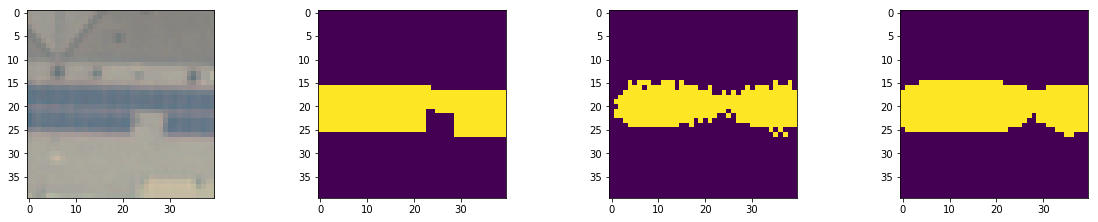

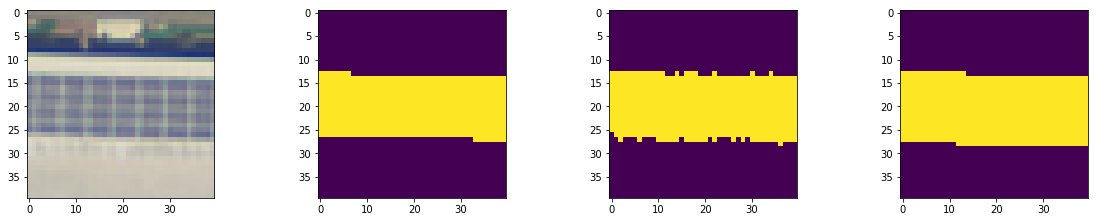

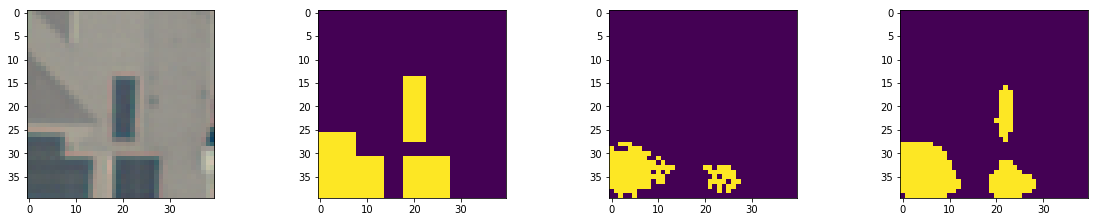

In [46]:
# worst
    for j in range(0, num_sample):
        left_up = np.max(np.array([region_center[mean_ind[-j-10]] - patch_size, np.array([0, 0])]), axis=0).astype(int)
        right_bottom = np.min(np.array([region_center[mean_ind[-j-10]] + patch_size, np.array([5000, 5000])]), axis=0).astype(int)
        image_patch = image[left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
        truth_patch = truth[left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
        plt.figure('best{}'.format(j), figsize=(20,20))
        plt.subplot(num_sample, validDir.__len__()+2, (validDir.__len__()+2)*j+1)
        plt.imshow(image_patch)
        plt.subplot(num_sample, validDir.__len__()+2, (validDir.__len__()+2)*j+2)
        plt.imshow(truth_patch)
        for k in range(validDir.__len__()):
            pred_patch = pred_binary[k][left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
            plt.subplot(num_sample, validDir.__len__()+2, (validDir.__len__()+2)*j+3+k)
            plt.imshow(pred_patch)

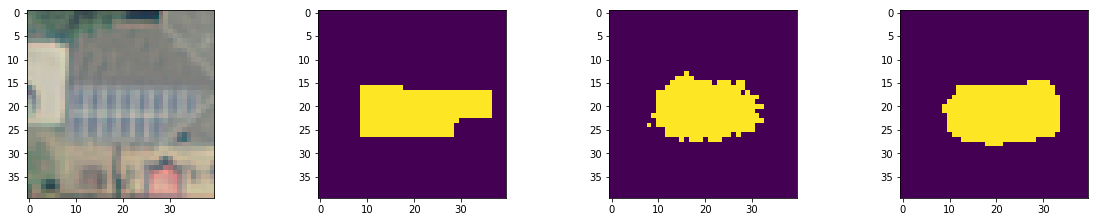

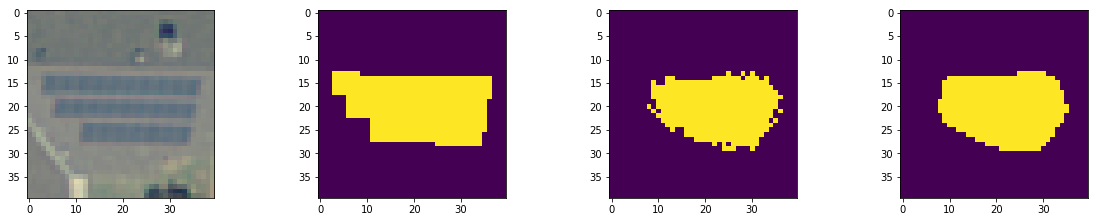

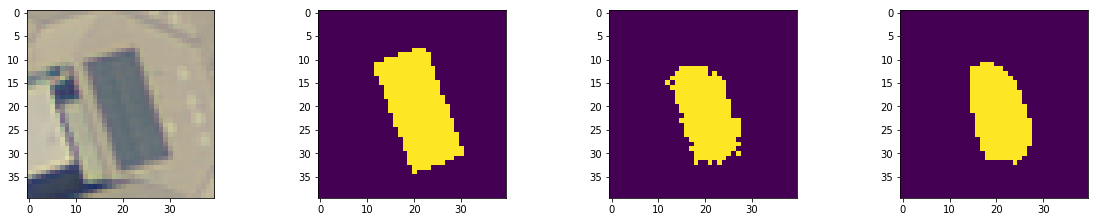

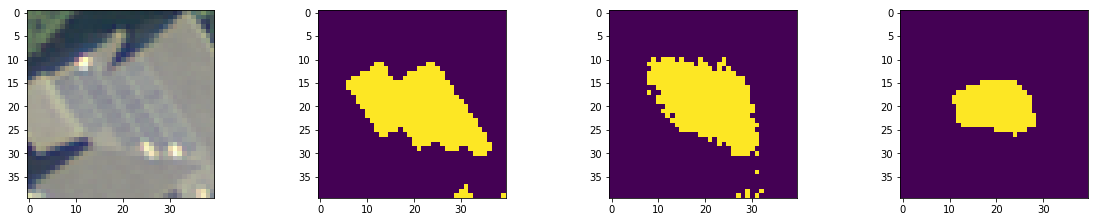

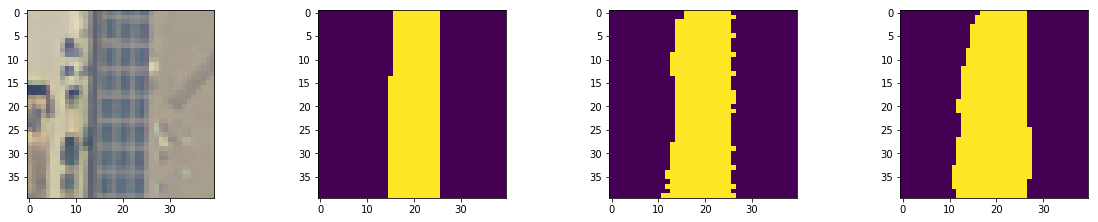

In [55]:
# most dif
for j in range(0, num_sample):
    left_up = np.max(np.array([region_center[var_ind[-j]] - patch_size, np.array([0, 0])]), axis=0).astype(int)
    right_bottom = np.min(np.array([region_center[var_ind[-j]] + patch_size, np.array([5000, 5000])]), axis=0).astype(int)
    image_patch = image[left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
    truth_patch = truth[left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
    plt.figure('diff{}'.format(j), figsize=(20,20))
    plt.subplot(num_sample, validDir.__len__()+2, (validDir.__len__()+2)*j+1)
    plt.imshow(image_patch)
    plt.subplot(num_sample, validDir.__len__()+2, (validDir.__len__()+2)*j+2)
    plt.imshow(truth_patch)
    for k in range(validDir.__len__()):
        pred_patch = pred_binary[k][left_up[0]:right_bottom[0], left_up[1]:right_bottom[1]]
        plt.subplot(num_sample, validDir.__len__()+2, (validDir.__len__()+2)*j+3+k)
        plt.imshow(pred_patch)

mean_IU: 0.513406292749658
mean_IU: 0.08839927453482904


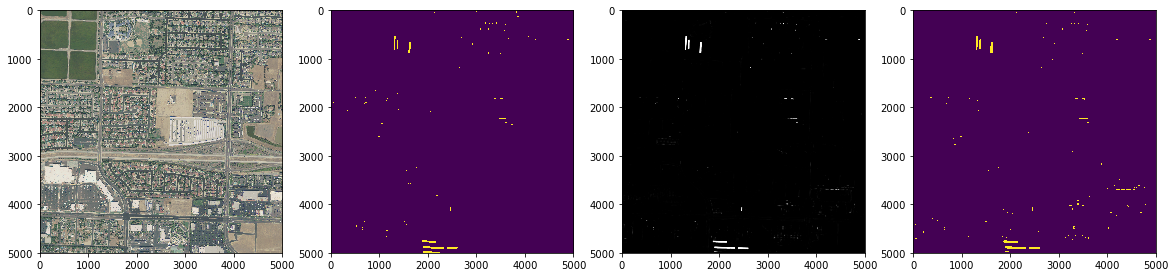

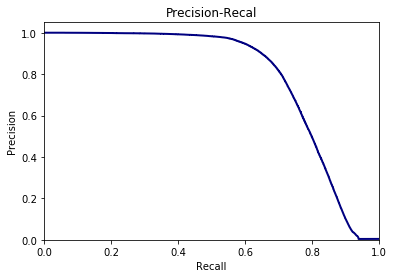

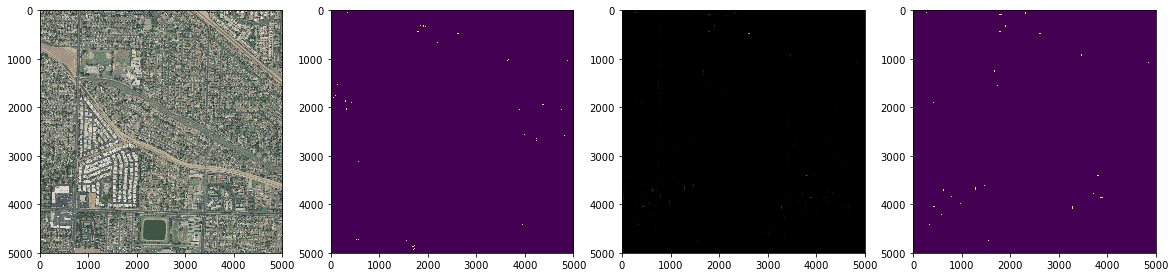

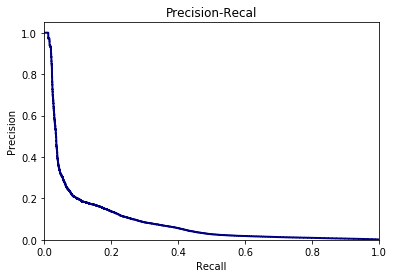

In [29]:
batch_size = 20
learning_rate = 1e-3
weight_decay = 0.0005
threshold = 0.1
validDir = os.path.join(os.path.realpath('../../tensorflow-deeplab-resnet/snapshots/train_upscale2_with_pretrained_model'), 'sc_all_batchsize{}_learningRate_{:.0e}_weight_decay_{}/'.format(batch_size, learning_rate, weight_decay),'images')
for i in range(0, num_val):
    image = misc.imread(os.path.join(truthDir,imageFileName[i].format('.png')))
    truth = (misc.imread(os.path.join(truthDir,imageFileName[i].format('_truth.png')))/255).astype(np.uint8)
    valid_pmap = misc.imread(os.path.join(validDir,imageFileName[i].format('_valid_pmap.tif')))
    pred_binary = misc.imread(os.path.join(validDir,imageFileName[i].format('_valid_pred.png')))
    pred_binary = (valid_pmap>threshold).astype(np.uint8)
    print("mean_IU: {}".format(mean_IU(pred_binary, truth)))
#     plt.figure(figsize=(20,10))
#     plt.subplot(num_val, 4, i*4+1)
#     plt.imshow(image[4500:5000,2000:2500])
#     plt.subplot(num_val, 4, i*4+2)
#     plt.imshow(truth[4500:5000,2000:2500])
#     plt.subplot(num_val, 4, i*4+3)
#     plt.imshow(valid_pmap[4500:5000,2000:2500], cmap = plt.cm.gray)
#     plt.subplot(num_val, 4, i*4+4)
#     plt.imshow(valid_pmap[4500:5000,2000:2500] > 0.5)
    plt.figure(figsize=(20,10))
    plt.subplot(num_val, 3, i*3+1)
    plt.imshow(image)
    plt.subplot(num_val, 3, i*3+2)
    plt.imshow(truth)
#     plt.subplot(num_val, 3, i*3+3)
#     plt.imshow(valid_pmap, cmap = plt.cm.gray)
    plt.subplot(num_val, 3, i*3+3)
    plt.imshow(valid_pmap > threshold)

    # Plot PR curve
    precision, recall, thresholds = precision_recall_curve(truth.flatten(), valid_pmap.flatten(), 1)
    
    plt.figure()
    plt.plot(recall, precision, lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recal')
    # plt.legend(loc="lower left")